In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxportfolio as cp

plotdir='../../portfolio/plots/'
datadir='data/' 

sigmas=pd.read_csv(datadir+'sigmas.csv.gz',index_col=0,parse_dates=[0])
returns=pd.read_csv(datadir+'returns.csv.gz',index_col=0,parse_dates=[0])
volumes=pd.read_csv(datadir+'volumes.csv.gz',index_col=0,parse_dates=[0])
a = pd.read_csv(datadir+'a.csv.gz',index_col=0,parse_dates=[0])
b = pd.read_csv(datadir+'b.csv.gz',index_col=0,parse_dates=[0])
s = pd.read_csv(datadir+'s.csv.gz',index_col=0,parse_dates=[0])

w_b = pd.Series(index=returns.columns, data=1)
w_b.USDOLLAR = 0.
w_b/=sum(w_b)

start_t="2012-01-01"
end_t="2016-12-31"

simulated_tcost = cp.TcostModel(volumes, sigmas, a, b, cash_key='USDOLLAR')
simulated_hcost = cp.HcostModel(s, cash_key='USDOLLAR')
simulator = cp.MarketSimulator(returns, volumes, [simulated_tcost, simulated_hcost], cash_key='USDOLLAR')

return_estimate=pd.read_csv(datadir+'return_estimate.csv.gz',index_col=0,parse_dates=[0])
volume_estimate=pd.read_csv(datadir+'volume_estimate.csv.gz',index_col=0,parse_dates=[0])
sigma_estimate=pd.read_csv(datadir+'sigma_estimate.csv.gz',index_col=0,parse_dates=[0])

alpha_model = cp.AlphaSource(return_estimate)
optimization_tcost=cp.TcostModel(volume_estimate, sigma_estimate, a, b, cash_key='USDOLLAR')
optimization_hcost=cp.HcostModel(s, cash_key='USDOLLAR')

risk_data = pd.HDFStore(datadir+'risk_model.h5')
risk_model = cp.FactorModelSigma(risk_data.exposures, risk_data.factor_sigma, risk_data.idyos)

results={}

# SPO coarse search

In [26]:
policies={}
gamma_risks_coarse=[.1,.3,1,3,10,30,100,300,1000]
gamma_tcosts_coarse=[1,2,5,10,20]
for gamma_risk in gamma_risks_coarse:
    for gamma_tcost in gamma_tcosts_coarse : 
        policies[(gamma_risk, gamma_tcost)] = \
      cp.SinglePeriodOpt(alpha_model, [gamma_risk*risk_model,gamma_tcost*optimization_tcost,optimization_hcost], 
                                [cp.LeverageLimit(3)])

import warnings
warnings.filterwarnings('ignore')
results.update(dict(zip(policies.keys(), simulator.run_multiple_backtest(1E8*w_b, start_time=start_t,end_time=end_t,
                                              policies=policies.values(), parallel=True))))

ERROR:root:The solver None failed. Defaulting to no trades
ERROR:root:The solver None failed. Defaulting to no trades
ERROR:root:The solver None failed. Defaulting to no trades


In [27]:
result_df_coarse=pd.DataFrame()
for k in results:
    if k[0] in gamma_risks_coarse and k[1] in gamma_tcosts_coarse:
        result_df_coarse.loc[k[0], k[1]] = results[k]
        
result_df = result_df_coarse.loc[sorted(result_df_coarse.index), sorted(result_df_coarse.columns)]

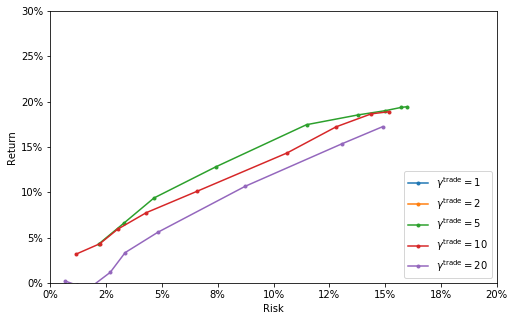

In [28]:
plt.figure(figsize=(8,5))
for gamma_tcost in result_df.columns:
    x=[el.excess_returns.std()*100*np.sqrt(250) for el in result_df[gamma_tcost]]
    y=[el.excess_returns.mean()*100*250 for el in result_df[gamma_tcost]]
    plt.plot(np.array(x),np.array(y), '.-', label='$\gamma^\mathrm{trade} = %g$'%gamma_tcost)
plt.legend(loc='lower right')
plt.xlabel('Risk')
plt.ylabel('Return')
plt.xlim([0,20])
plt.ylim([0,30])


import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))

plt.savefig(plotdir+'spo_riskrewardfrontier.png')

# SPO fine Search 

In [30]:
policies={}
gamma_risks_fine=gamma_risks_coarse
gamma_tcosts_fine=[4,5,6,7,8]
for gamma_risk in gamma_risks_fine:
    for gamma_tcost in gamma_tcosts_fine : 
        policies[(gamma_risk, gamma_tcost)] = \
      cp.SinglePeriodOpt(alpha_model, [gamma_risk*risk_model,gamma_tcost*optimization_tcost,optimization_hcost], 
                                [cp.LeverageLimit(3)])

import warnings
warnings.filterwarnings('ignore')
results.update(dict(zip(policies.keys(), simulator.run_multiple_backtest(1E8*w_b, start_time=start_t,end_time=end_t,
                                              policies=policies.values(), parallel=True))))

In [31]:
result_df_fine=pd.DataFrame()
for k in results:
    if k[0] in gamma_risks_fine and k[1] in list(gamma_tcosts_fine):
        result_df_fine.loc[k[0], k[1]] = results[k]
        
result_df_fine=result_df_fine.loc[sorted(result_df_fine.index),sorted(result_df_fine.columns)]

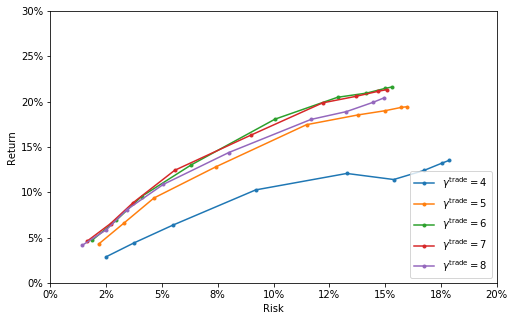

In [32]:
plt.figure(figsize=(8,5))
for gamma_tcost in result_df_fine.columns[:]:
    x=[el.excess_returns.std()*100*np.sqrt(250) for el in result_df_fine[gamma_tcost]]
    y=[el.excess_returns.mean()*100*250 for el in result_df_fine[gamma_tcost]]
    plt.plot(np.array(x),np.array(y), '.-', label='$\gamma^\mathrm{trade} = %g$'%gamma_tcost)
plt.legend(loc='lower right')
plt.xlabel('Risk')
plt.ylabel('Return')
plt.xlim([0,20])
plt.ylim([0,30])


import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))

plt.savefig(plotdir+'spo_riskrewardfrontier_fine.png')

# SPO Pareto search 

In [20]:
results_pareto={}

In [57]:
policies={}
#gamma_risks_pareto=[int(round(el)) if el>1 else el for el in np.logspace(-1,3,17)]
gamma_risks_pareto=[0.1, 0.17782, 0.31624, 0.562, 1.0, 2, 3, 6, 10, 18, 32, 56, 100, 178, 316, 562, 1000]
gamma_tcosts_pareto=[5.5,6,6.5,7,7.5,8]
gamma_holdings=[.1,1.,10.,100.,1000.]
for gamma_risk in gamma_risks_pareto:
    for gamma_tcost in gamma_tcosts_pareto : 
        for gamma_holding in gamma_holdings:
            policies[(gamma_risk, gamma_tcost, gamma_holding)] = \
          cp.SinglePeriodOpt(alpha_model, [gamma_risk*risk_model,gamma_tcost*optimization_tcost,\
                                       gamma_holding*optimization_hcost], 
                                [cp.LeverageLimit(3)])

import warnings
warnings.filterwarnings('ignore')
results_pareto.update(dict(zip(policies.keys(), simulator.run_multiple_backtest(1E8*w_b, start_time=start_t,end_time=end_t,
                                              policies=policies.values(), parallel=True))))

In [58]:
table=pd.DataFrame()
table[r'$\gamma^\mathrm{risk}$']=[el[0] for el in results_pareto.keys()]
table[r'$\gamma^\mathrm{trade}$']=[el[1] for el in results_pareto.keys()]
table[r'$\gamma^\mathrm{hold}$']=['%g'%el[2] for el in results_pareto.keys()]
table['Return']=[(results_pareto[k].excess_returns.mean()*100*250) for k in results_pareto.keys()]
table['Risk']=[(results_pareto[k].excess_returns.std()*100*np.sqrt(250)) for k in results_pareto.keys()]
table = table.sort_values('Risk', ascending=False).reset_index()
del table['index']
is_pareto = lambda i: table.loc[i,'Return']>=max(table.ix[i:].Return)
table['is_pareto'] = [is_pareto(i) for i in range(len(table))]
table.to_csv(datadir+'spo_pareto_results.csv', float_format='%g')

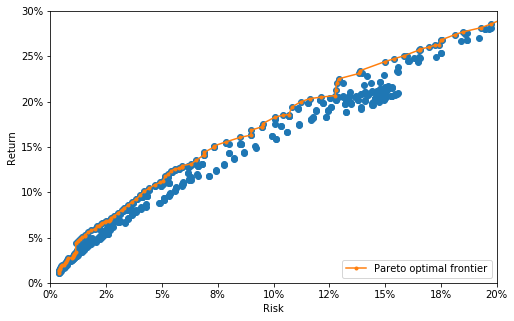

In [59]:
plt.figure(figsize=(8,5))
plt.scatter(table.Risk.values,table.Return.values)
plt.plot(table[table.is_pareto].Risk,table[table.is_pareto].Return, 'C1.-', label='Pareto optimal frontier')
plt.legend( loc='lower right')
plt.xlabel('Risk')
plt.ylabel('Return')
plt.xlim([0,20])
plt.ylim([0,30])

import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))

plt.savefig(plotdir+'spo_pareto.png')

In [60]:
xlim=20
ylim=30
table=table[table.is_pareto]
table=table[table.Risk <= xlim]
table=table[table.Return <= ylim]
del table['is_pareto']
table.Risk=table.Risk.apply(lambda x: '%.2f%%'%x)
table.Return=table.Return.apply(lambda x: '%.2f%%'%x)
print(table.iloc[::-1].to_latex(float_format='%.2f', escape=False, index=False).replace('%',r'\%'))

\begin{tabular}{rrlll}
\toprule
 $\gamma^\mathrm{risk}$ &  $\gamma^\mathrm{trade}$ & $\gamma^\mathrm{hold}$ &  Return &    Risk \\
\midrule
                1000.00 &                      8.0 &                   1000 &   1.09\% &   0.38\% \\
                1000.00 &                      8.0 &                    100 &   1.33\% &   0.39\% \\
                1000.00 &                      7.5 &                    100 &   1.43\% &   0.41\% \\
                1000.00 &                      7.0 &                    100 &   1.54\% &   0.43\% \\
                1000.00 &                      6.5 &                    100 &   1.67\% &   0.45\% \\
                1000.00 &                      6.0 &                    100 &   1.82\% &   0.47\% \\
                1000.00 &                      5.5 &                    100 &   1.97\% &   0.50\% \\
                 562.00 &                      7.5 &                    100 &   2.00\% &   0.63\% \\
                 562.00 &                      7.0 &